In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score

In [2]:
# Load datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Display basic info
print(customers.info())
print(products.info())
print(transactions.info())

# Check for null values
print(customers.isnull().sum())
print(products.isnull().sum())
print(transactions.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------

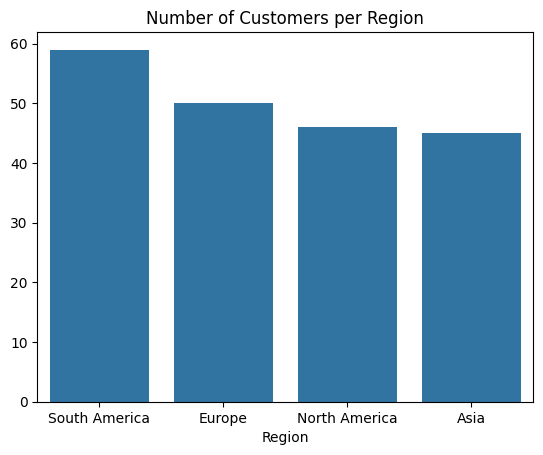

In [3]:
# Number of customers per region
region_counts = customers['Region'].value_counts()
sns.barplot(x=region_counts.index, y=region_counts.values)
plt.title("Number of Customers per Region")
plt.show()

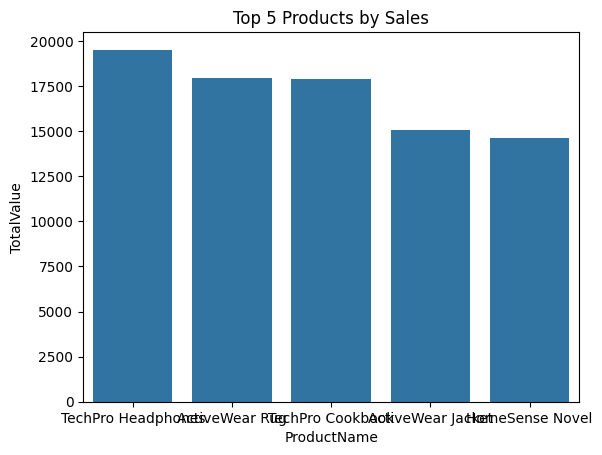

In [4]:
# Top 5 products by sales
top_products = transactions.groupby('ProductID')['TotalValue'].sum().nlargest(5)
top_products = top_products.reset_index().merge(products, on='ProductID')
sns.barplot(data=top_products, x='ProductName', y='TotalValue')
plt.title("Top 5 Products by Sales")
plt.show()

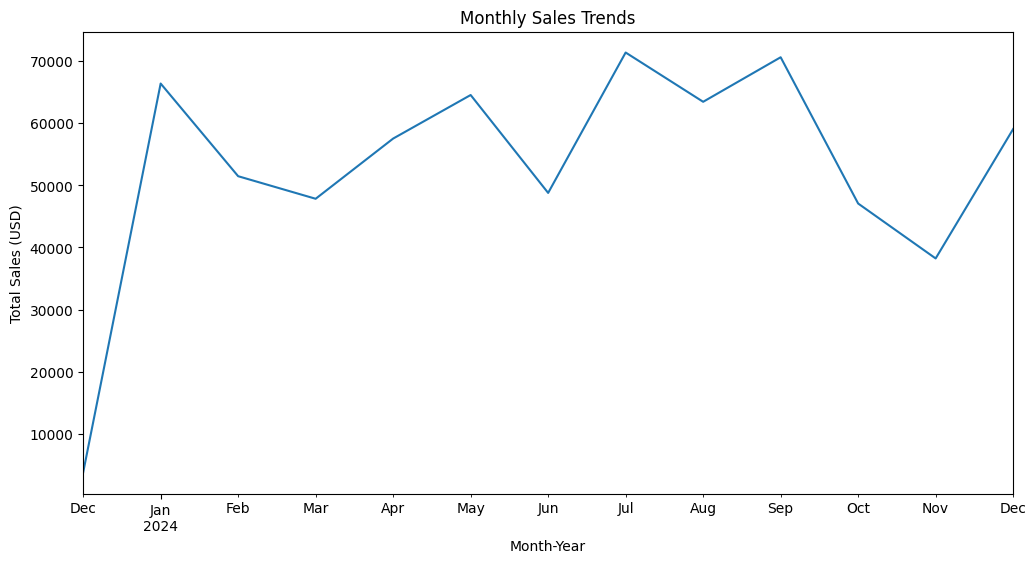

In [5]:
# Transaction trends over time
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions['MonthYear'] = transactions['TransactionDate'].dt.to_period('M')
monthly_sales = transactions.groupby('MonthYear')['TotalValue'].sum()
monthly_sales.plot(kind='line', figsize=(12, 6))
plt.title("Monthly Sales Trends")
plt.xlabel("Month-Year")
plt.ylabel("Total Sales (USD)")
plt.show()


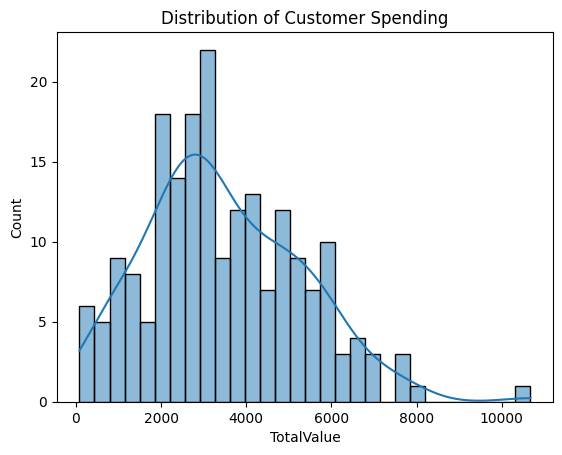

In [6]:
# Average spending per customer
customer_spending = transactions.groupby('CustomerID')['TotalValue'].sum()
sns.histplot(customer_spending, bins=30, kde=True)
plt.title("Distribution of Customer Spending")
plt.show()


In [8]:
# Verify datasets
print(customers.head())
print(products.head())
print(transactions.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID     TransactionDate  Quantity  \
0        T00001      C0199      P067 2024-08-25 12:38:23         1   
1        T00112      C0146      P067 2024-05-27 22:23:54         1   
2        T00166      C0127      P067 2024-04-25 07:38:55         1   
3        T00

In [9]:
# Merge datasets
merged_data = transactions.merge(customers, on='CustomerID', how='inner')
merged_data = merged_data.merge(products, on='ProductID', how='inner')

# Check merged data
print(merged_data.head())
print(merged_data.info())


  TransactionID CustomerID ProductID     TransactionDate  Quantity  \
0        T00001      C0199      P067 2024-08-25 12:38:23         1   
1        T00112      C0146      P067 2024-05-27 22:23:54         1   
2        T00166      C0127      P067 2024-04-25 07:38:55         1   
3        T00272      C0087      P067 2024-03-26 22:55:37         2   
4        T00363      C0070      P067 2024-03-21 15:10:10         3   

   TotalValue  Price_x MonthYear   CustomerName_x       Region_x SignupDate_x  \
0      300.68   300.68   2024-08   Andrea Jenkins         Europe   2022-12-03   
1      300.68   300.68   2024-05  Brittany Harvey           Asia   2024-09-04   
2      300.68   300.68   2024-04  Kathryn Stevens         Europe   2024-04-04   
3      601.36   300.68   2024-03  Travis Campbell  South America   2024-04-11   
4      902.04   300.68   2024-03    Timothy Perez         Europe   2022-03-15   

                     ProductName_x   Category_x  Price_y   CustomerName_y  \
0  ComfortLivin

In [10]:
# Aggregate customer-level features
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Price': 'mean',
    'Category': lambda x: x.mode()[0]  # Most frequent category
}).reset_index()

# Verify features
print(customer_features.head())


KeyError: "Column(s) ['Category'] do not exist"

In [11]:
print(products.columns)

Index(['ProductID', 'ProductName', 'Category', 'Price'], dtype='object')


In [12]:
# Check the merged DataFrame columns
print(merged_data.columns)


Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price_x', 'MonthYear', 'CustomerName_x',
       'Region_x', 'SignupDate_x', 'ProductName_x', 'Category_x', 'Price_y',
       'CustomerName_y', 'Region_y', 'SignupDate_y', 'ProductName_y',
       'Category_y', 'Price'],
      dtype='object')


In [13]:
# Correct merge
merged_data = transactions.merge(products, on='ProductID', how='inner').merge(customers, on='CustomerID', how='inner')


In [14]:
# Without 'Category'
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Price': 'mean'
}).reset_index()

print(customer_features.head())


  CustomerID  TotalValue  Quantity       Price
0      C0001     3354.52        12  278.334000
1      C0002     1862.74        10  208.920000
2      C0003     2725.38        14  195.707500
3      C0004     5354.88        23  240.636250
4      C0005     2034.24         7  291.603333


In [17]:
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Price': 'mean',
    'Category': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown'
}).reset_index()

print(customer_features.head())


KeyError: "Column(s) ['Category'] do not exist"

In [18]:
# Check the Products dataset
print(products.columns)

# Verify the first few rows
print(products.head())


Index(['ProductID', 'ProductName', 'Category', 'Price'], dtype='object')
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31


In [19]:
# Merge transactions with products and customers
merged_data = transactions.merge(products, on='ProductID', how='inner').merge(customers, on='CustomerID', how='inner')

# Check columns in the merged dataset
print(merged_data.columns)


Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price_x', 'MonthYear', 'CustomerName_x',
       'Region_x', 'SignupDate_x', 'ProductName_x', 'Category_x', 'Price_y',
       'ProductName_y', 'Category_y', 'Price', 'CustomerName_y', 'Region_y',
       'SignupDate_y'],
      dtype='object')


In [20]:
products['Category'] = 'Unknown'  # Add a default 'Category'


In [21]:
# Aggregate customer-level features without 'Category'
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Price': 'mean'  # Average price per customer
}).reset_index()

print(customer_features.head())


  CustomerID  TotalValue  Quantity       Price
0      C0001     3354.52        12  278.334000
1      C0002     1862.74        10  208.920000
2      C0003     2725.38        14  195.707500
3      C0004     5354.88        23  240.636250
4      C0005     2034.24         7  291.603333


In [23]:
# Handle mode computation safely
'Category': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown'


SyntaxError: illegal target for annotation (2079336387.py, line 2)

In [24]:
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Price': 'mean',
    'Category': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
}).reset_index()

print(customer_features.head())


KeyError: "Column(s) ['Category'] do not exist"

In [25]:
print(merged_data['Category'].unique())


KeyError: 'Category'

In [26]:
'Category': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown'


SyntaxError: illegal target for annotation (390964209.py, line 1)

In [27]:
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Price': 'mean',
    'Category': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown'
}).reset_index()

print(customer_features.head())


KeyError: "Column(s) ['Category'] do not exist"